# Step 1: Unzip the zip file to extact the stl files into train, test and val folders


In [ ]:
import zipfile
import os
import shutil
import random

# 1️⃣ Set paths
zip_path = "/content/bolts.zip"  # ✅ your ZIP file path
extract_dir = "/content/extracted_bolts"
output_dir = "/content/bolts_dataset"

# 2️⃣ Unzip all .stl files
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

# 3️⃣ Collect and shuffle all .stl files
all_files = [f for f in os.listdir(extract_dir) if f.endswith('.stl')]
random.seed(42)
random.shuffle(all_files)

# 4️⃣ Split into train, test, val
train_files = all_files[:900]
test_files = all_files[900:980]
val_files = all_files[980:1000]

# 5️⃣ Create directories
os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "val"), exist_ok=True)

# 6️⃣ Move files
for f in train_files:
    shutil.move(os.path.join(extract_dir, f), os.path.join(output_dir, "train", f))
for f in test_files:
    shutil.move(os.path.join(extract_dir, f), os.path.join(output_dir, "test", f))
for f in val_files:
    shutil.move(os.path.join(extract_dir, f), os.path.join(output_dir, "val", f))

# 7️⃣ Print summary
print("✅ Split complete!")
print("Train:", len(os.listdir(os.path.join(output_dir, "train"))))
print("Test:", len(os.listdir(os.path.join(output_dir, "test"))))
print("Val:", len(os.listdir(os.path.join(output_dir, "val"))))



✅ Split complete!
Train: 900
Test: 80
Val: 20


#Pre-processing the stl files into point clouds

In [ ]:
!pip install open3d

✅ STL to Point Cloud completed. Shape: (4096, 3)


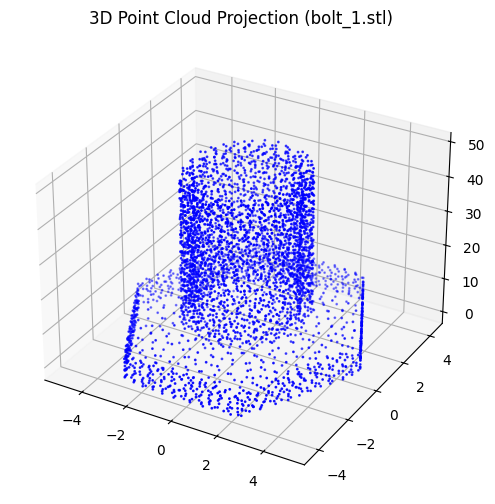

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# a test for single file
# 1️⃣ Load STL mesh
mesh = o3d.io.read_triangle_mesh("/content/bolts_dataset/train/bolt_1.stl")

# 2️⃣ Check if mesh has normals (optional, for lighting)
if not mesh.has_vertex_normals():
    mesh.compute_vertex_normals()

# 3️⃣ Sample N points from mesh surface
pcd = mesh.sample_points_poisson_disk(number_of_points=4096)


# 4️⃣ Convert to numpy array
points = np.asarray(pcd.points)  # shape: (4096, 3)

# 5️⃣ Save to .npy (for PointNet input)
#np.save("/content/bolt_1.npy", points)

print("✅ STL to Point Cloud completed. Shape:", points.shape)

# Optional: visualize point cloud
#o3d.visualization.draw_geometries([pcd])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='blue')
ax.set_title('3D Point Cloud Projection (bolt_1.stl)')
plt.show()


✅ Sampled point cloud shape: (4096, 3)
✅ Corresponding normals shape: (4096, 3)


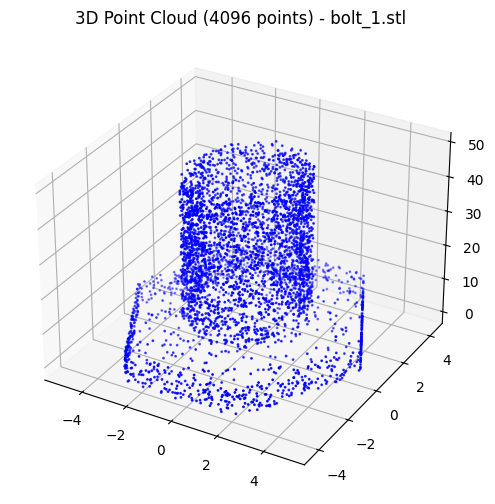

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Path to STL file
stl_path = "/content/bolts_dataset/train/bolt_1.stl"

# Load STL mesh
mesh = o3d.io.read_triangle_mesh(stl_path)

# Ensure the mesh has vertex normals for better surface info
if not mesh.has_vertex_normals():
    mesh.compute_vertex_normals()

# Sample a denser point cloud (4096 points)
pcd = mesh.sample_points_uniformly(number_of_points=4096)

# Extract coordinates of sampled points
points = np.asarray(pcd.points)

# Optional: Extract normals (for richer geometric learning)
# These normals can be concatenated with XYZ input to PointNet-like models
normals = np.asarray(pcd.normals)

print("✅ Sampled point cloud shape:", points.shape)
print("✅ Corresponding normals shape:", normals.shape)

# Visualize point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='blue')
ax.set_title('3D Point Cloud (4096 points) - bolt_1.stl')
plt.show()


#Comparison for denser representation

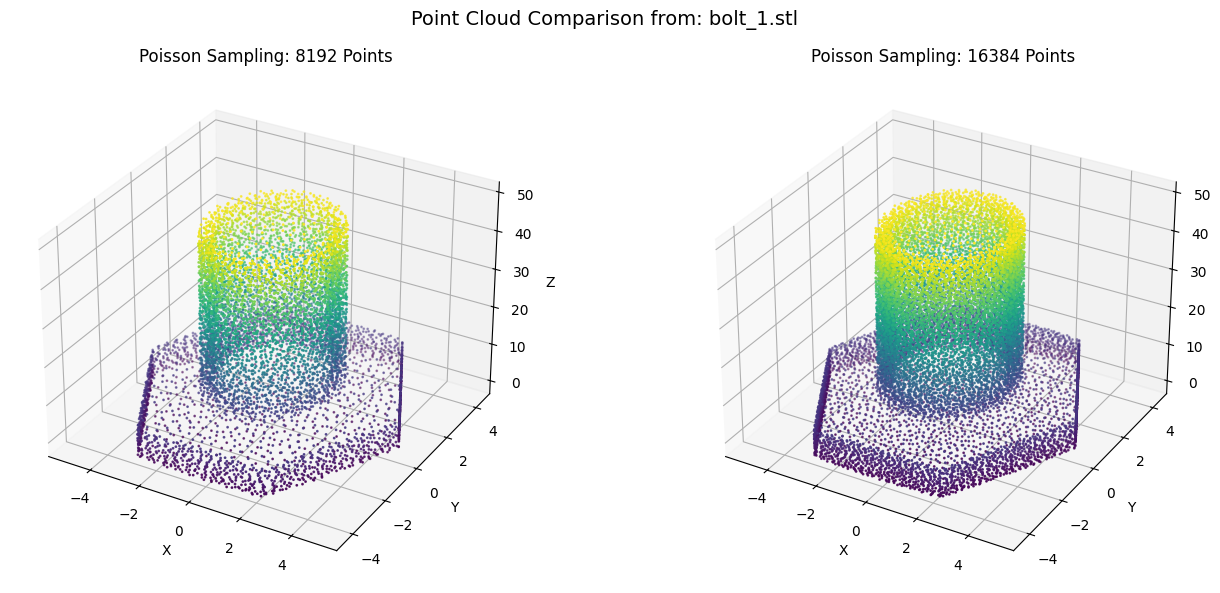

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# SETTINGS
stl_file = "/content/bolts_dataset/train/bolt_1.stl"
num_points_list = [8192, 16384 ]  # Compare both
use_poisson_sampling = True     # Set False to use uniform sampling

# Load mesh
mesh = o3d.io.read_triangle_mesh(stl_file)
mesh.compute_vertex_normals()

# Function to sample point cloud
def sample_points(mesh, n_points, method='poisson'):
    if method == 'poisson':
        return mesh.sample_points_poisson_disk(number_of_points=n_points)
    else:
        return mesh.sample_points_uniformly(number_of_points=n_points)

# Create subplots for each setting
fig = plt.figure(figsize=(14, 6))

for i, n_points in enumerate(num_points_list):
    method = 'poisson' if use_poisson_sampling else 'uniform'
    pcd = sample_points(mesh, n_points, method)
    points = np.asarray(pcd.points)

    ax = fig.add_subplot(1, 2, i + 1, projection='3d')
    sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                    c=points[:, 2], cmap='viridis', s=1)  # Color by Z-axis (height)
    ax.set_title(f"{method.title()} Sampling: {n_points} Points")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

plt.suptitle(f"Point Cloud Comparison from: {stl_file.split('/')[-1]}", fontsize=14)
plt.tight_layout()
plt.show()


#Converting all files into point cloud files


In [ ]:
import open3d as o3d
import numpy as np
import os

# Sampling settings
n_points = 16384
sampling_method = 'poisson'  # or 'uniform'

# Input and output paths
input_dirs = {
    "train": "/content/bolts_dataset/train",
    "test": "/content/bolts_dataset/test",
    "val": "/content/bolts_dataset/val"
}
output_base_dir = "/content/pointnet_data"

# Create output structure
os.makedirs(output_base_dir, exist_ok=True)

# Function to sample point cloud
def sample_points(mesh, n_points, method='poisson'):
    if method == 'poisson':
        return mesh.sample_points_poisson_disk(number_of_points=n_points)
    else:
        return mesh.sample_points_uniformly(number_of_points=n_points)

# Process each split
for split_name, input_dir in input_dirs.items():
    output_dir = os.path.join(output_base_dir, split_name)
    os.makedirs(output_dir, exist_ok=True)

    stl_files = [f for f in os.listdir(input_dir) if f.endswith(".stl")]
    print(f"🔄 Processing {len(stl_files)} files in {split_name} set...")

    for filename in stl_files:
        mesh_path = os.path.join(input_dir, filename)
        mesh = o3d.io.read_triangle_mesh(mesh_path)
        mesh.compute_vertex_normals()

        pcd = sample_points(mesh, n_points, method=sampling_method)
        points = np.asarray(pcd.points)

        output_filename = os.path.splitext(filename)[0] + ".npy"
        output_path = os.path.join(output_dir, output_filename)
        np.save(output_path, points)

    print(f"✅ Saved {len(stl_files)} point clouds in: {output_dir}")


# Model Architecture PointNet

In [ ]:
class Point_Net(nn.Module):
    def __init__(self, number_of_classes):
        super(Point_Net, self).__init__()
        self.T_Net3 = T_Net(3)
        self.ConvSet_1 = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=32, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=1, stride=1)
        )
        self.T_Net64 = T_Net(64)
        self.ConvSet_2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.MaxPool1d(kernel_size=1, stride=1)
        )
        self.FC_Layers = nn.Sequential(
            nn.MaxPool1d(1024),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, number_of_classes),
        )

    def forward(self, x):
        Tnet3 = self.T_Net3(x)
        x = torch.bmm(torch.transpose(x,1,2), Tnet3).transpose(1,2)
        x = self.ConvSet_1(x)
        Tnet64 = self.T_Net64(x)
        x = torch.bmm(torch.transpose(x,1,2), Tnet64).transpose(1,2)
        x = self.ConvSet_2(x)
        x = self.FC_Layers(x)
        return x